In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import json
from keras.models import load_model
import pandas as pd
from scipy.stats import pearsonr
from keras.utils.generic_utils import get_custom_objects
from losses import neg_log_likelihood
from util import partition_data, get_balaji_predictions, get_experimental_X_y, get_gfp_X_y_aa
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams["font.family"] = "serif"
cm = plt.get_cmap('viridis_r')
plt.style.use('seaborn-paper')


Using TensorFlow backend.


In [2]:

ALL_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
METHODS = [
    'kl_den_log_sf_fitness_315_sim_0985_p_margin_1_decoder_eps_00001_fitness_weight_005',
    'kl_den_log_sf_fitness_315_sim_095_p_margin_1_decoder_eps_00001_fitness_weight_005',
    'kl_den_log_sf_fitness_315_sim_09_p_margin_1_decoder_eps_00001_fitness_weight_005',
    'cbas',
    'fbvae',
    'cem-pi'
]
METHOD_COLORS = {METHODS[i]: ALL_COLORS[i] for i in range(len(METHODS))}
METHOD_COLORS['killoran'] = ALL_COLORS[len(METHODS)]


In [3]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [4]:
def plot_comparison(quantiles, mean=False, use_from=0, use_first=50, methods_to_use=None, repeat_start=0, repeats=3, figsize=(4, 3), sort_by='oracle', plot_type='fitness', min_y_val=2.9, max_y_val=3.4):
    fig = plt.figure(figsize=figsize)
    width = 0.25
    ml_methods = methods_to_use if methods_to_use is not None else ['cbas', 'fbvae', 'dbas', 'rwr', 'cem-pi']
    all_methods = deepcopy(ml_methods)
    include_killoran_bomb = False#True
    total = len(ml_methods)
    if include_killoran_bomb:
        total += 1
        all_methods += ['killoran']
    shades = [0.4, 0.6, 0.8, 1]
    results = np.zeros((len(quantiles), total, repeats))
    for i in range(1, 4):  # Loop over random state
        for j in range(len(ml_methods)):
            for k in range(repeat_start, repeats):
                suffix = '_5k_%i_%i_w_edit_distances' % (i, k)
                method = ml_methods[j]

                oracle_samples = np.load("results/%s_oracle_samples%s.npy" %(method, suffix))[use_from:use_first]
                gt_samples = np.load("results/%s_gt_samples%s.npy" %(method, suffix))[use_from:use_first]
                edit_distance_samples = np.load("results/%s_edit_distance_samples%s.npy" %(method, suffix))[use_from:use_first]

                oracle_samples = oracle_samples.flatten()
                gt_samples = gt_samples.flatten()
                edit_distance_samples = edit_distance_samples.flatten()
                for l in range(len(quantiles)):
                    quantile = quantiles[l]

                    if sort_by == 'oracle' :
                        top_oracle_idxs = np.where(oracle_samples >= np.percentile(oracle_samples, quantile*100))
                        gt_at_top_oracle = gt_samples[top_oracle_idxs]
                        edit_distance_at_top_oracle = edit_distance_samples[top_oracle_idxs]
                        results[l, j, k] = np.mean(gt_at_top_oracle) if plot_type == 'fitness' else np.mean(edit_distance_at_top_oracle)
                    elif sort_by == 'ground_truth' :
                        top_oracle_idxs = np.where(gt_samples >= np.percentile(gt_samples, quantile*100))
                        gt_at_top_oracle = gt_samples[top_oracle_idxs]
                        edit_distance_at_top_oracle = edit_distance_samples[top_oracle_idxs]
                        results[l, j, k] = np.mean(gt_at_top_oracle) if plot_type == 'fitness' else np.mean(edit_distance_at_top_oracle)
                    elif sort_by == 'edit_distance' :
                        top_oracle_idxs = np.where(edit_distance_samples >= np.percentile(edit_distance_samples, quantile*100))
                        gt_at_top_oracle = gt_samples[top_oracle_idxs]
                        edit_distance_at_top_oracle = edit_distance_samples[top_oracle_idxs]
                        results[l, j, k] = np.mean(gt_at_top_oracle) if plot_type == 'fitness' else np.mean(edit_distance_at_top_oracle)

        if include_killoran_bomb:
            killoran_results = np.load("results/killoran_max_results_5k_%i.npy" % i)
            results[l, len(ml_methods), :] = killoran_results[-1, 1]

        xs = range(total)
        xs = [xi + i*width for xi in xs]
        for j in range(total):
            for l in range(len(quantiles)):
                method = all_methods[j]
                c = METHOD_COLORS[method]
                val = results[l, j, repeat_start:].mean(axis=-1)
                if i == 1 and j == 0:
                    lbl = "$%i^{th}$ Percentile" % int(100*quantiles[l])
                else:
                    lbl=None
                if l == 0:
                    plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), 
                            edgecolor='k', linewidth=0.5, label=lbl, zorder=l+1)
                else:
                    prev_val = results[l-1, j, repeat_start:].mean(axis=-1)
                    plt.bar(xs[j],val-prev_val, width=width, 
                            bottom = prev_val,
                            color=lighten_color(c, shades[l]), edgecolor='k', 
                            linewidth=0.5, label=lbl, zorder=l+1)
        prev_results = results

    plt.xticks([i + 2*width for i in range(total)])
    all_lbls = [ml_methods[j].upper() for j in range(len(ml_methods))]
    for i in range(len(all_lbls)):
        if all_lbls[i] == 'CBAS':
            all_lbls[i] = 'CbAS'
        elif all_lbls[i] == 'DBAS':
            all_lbls[i] = 'DbAS'
        elif all_lbls[i] == 'KILLORAN':
            all_lbls[i] = 'Killoran'
        elif 'KL_DEN' in all_lbls[i] :
            all_lbls[i] = 'KL_DEN (' + str(i+1) + ')'
            
    if include_killoran_bomb:
        all_lbls += ['AM-VAE']#['GB', 'GB-NO', 'AM-VAE']
    plt.gca().set_xticklabels(all_lbls, rotation=60)
    y_label = "Ground Truth Values"
    
    plt.ylabel(y_label)
    plt.ylim([min_y_val, max_y_val])
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.gca().grid(color='gray', alpha=0.2)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    
    plt.legend(fontsize=5, frameon=True, loc='upper right')
    leg = plt.gca().get_legend()
    for l in range(len(quantiles)):
        leg.legendHandles[l].set_color(lighten_color(ALL_COLORS[7], shades[l]))
        leg.legendHandles[l].set_edgecolor('k')
    plt.tight_layout()
    
    plt.savefig("plots/gfp_sf_kl_den_" + str(sort_by) + "_" + str(use_from) + "_" + str(use_first) + "_" + plot_type + "_w_edit_distances.png", dpi=150, transparent=True)
    plt.savefig("plots/gfp_sf_kl_den_" + str(sort_by) + "_" + str(use_from) + "_" + str(use_first) + "_" + plot_type + "_w_edit_distances.eps")
    plt.savefig("plots/gfp_sf_kl_den_" + str(sort_by) + "_" + str(use_from) + "_" + str(use_first) + "_" + plot_type + "_w_edit_distances.svg")
    
    plt.show()


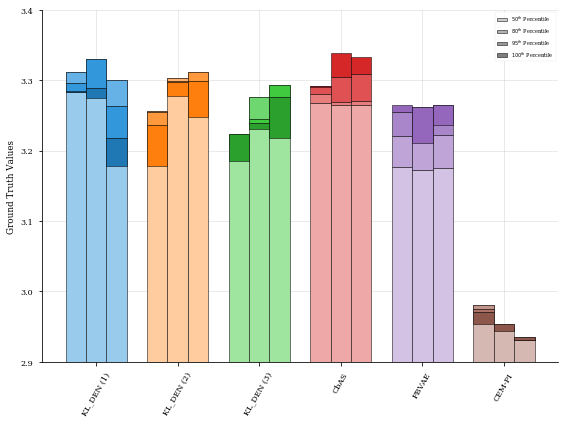

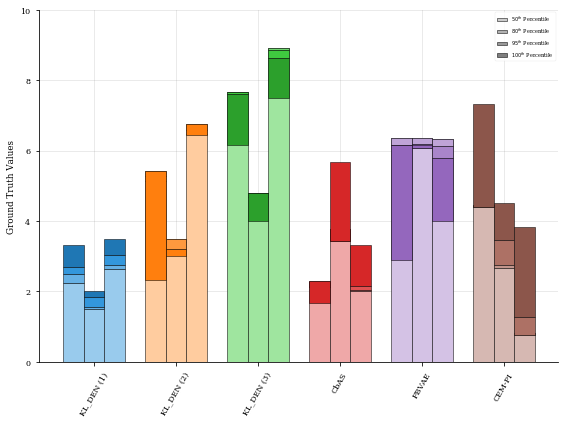

In [5]:
plot_comparison(quantiles=[0.5, 0.8, 0.95, 1], mean=False, repeats=3, figsize=(8, 6), use_from=10, use_first=50, methods_to_use=METHODS, sort_by='oracle', min_y_val=2.9, max_y_val=3.4)
plot_comparison(quantiles=[0.5, 0.8, 0.95, 1], mean=False, repeats=3, figsize=(8, 6), use_from=10, use_first=50, methods_to_use=METHODS, sort_by='oracle', plot_type='edit_distance', min_y_val=0, max_y_val=10)

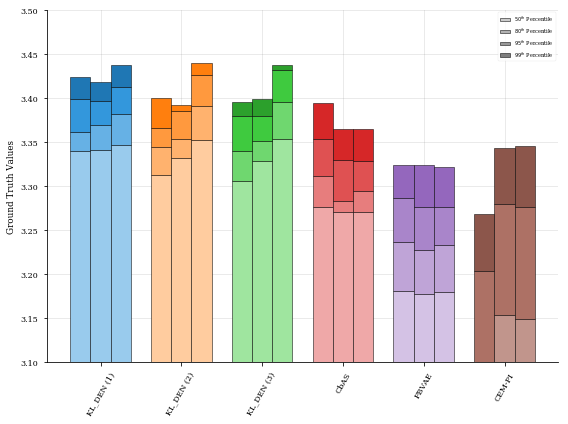

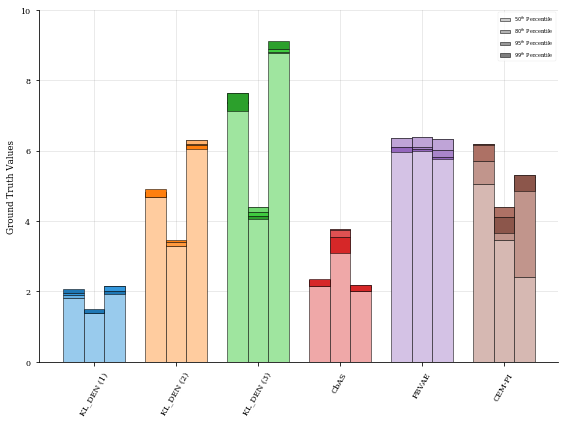

In [6]:
plot_comparison(quantiles=[0.5, 0.8, 0.95, 0.99], mean=False, repeat_start=0, repeats=3, figsize=(8, 6), use_from=10, use_first=50, methods_to_use=METHODS, sort_by='ground_truth', min_y_val=3.1, max_y_val=3.5)
plot_comparison(quantiles=[0.5, 0.8, 0.95, 0.99], mean=False, repeat_start=0, repeats=3, figsize=(8, 6), use_from=10, use_first=50, methods_to_use=METHODS, sort_by='ground_truth', plot_type='edit_distance', min_y_val=0, max_y_val=10)

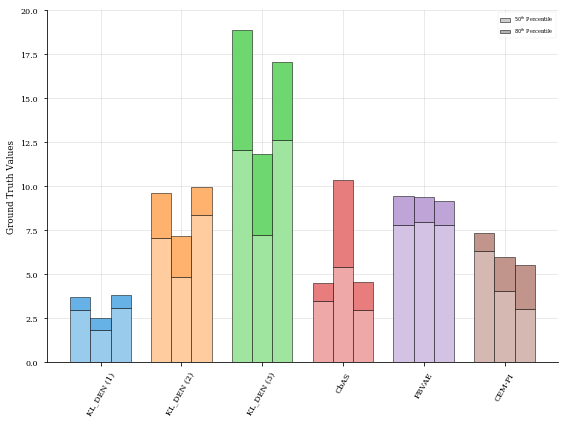

In [20]:
plot_comparison(quantiles=[0.5, 0.8], mean=False, repeat_start=0, repeats=3, figsize=(8, 6), use_from=10, use_first=50, methods_to_use=METHODS, sort_by='edit_distance', plot_type='edit_distance', min_y_val=0, max_y_val=20)

In [8]:
import seaborn as sns

from matplotlib import colors

def plot_comparison_violins(use_from=0, use_first=50, methods_to_use=None, repeat_start=0, repeats=3, figsize=(4, 3), sort_by='oracle', min_y_val=2.9, max_y_val=3.4):
    f = plt.figure(figsize=figsize)
    width = 0.25
    ml_methods = methods_to_use if methods_to_use is not None else ['cbas', 'fbvae', 'dbas', 'rwr', 'cem-pi']
    all_methods = deepcopy(ml_methods)
    include_killoran_bomb = True
    total = len(ml_methods)
    
    measurements = []
    measurement_colors = []
    method_names = []
    method_ticks = []
    
    for j in range(len(ml_methods)):
        method = ml_methods[j]
        c = METHOD_COLORS[method]
        
        for i in range(1, 4):
            total_meas = []
            
            for k in range(repeat_start, repeats):
                suffix = '_5k_%i_%i_w_edit_distances' % (i, k)
                
                oracle_samples = np.load("results/%s_oracle_samples%s.npy" %(method, suffix))[use_from:use_first]
                gt_samples = np.load("results/%s_gt_samples%s.npy" %(method, suffix))[use_from:use_first]
                edit_distance_samples = np.load("results/%s_edit_distance_samples%s.npy" %(method, suffix))[use_from:use_first]
                
                if sort_by == 'oracle' :
                    total_meas.append(np.ravel(oracle_samples))
                elif sort_by == 'ground_truth' :
                    total_meas.append(np.ravel(gt_samples))
                else :
                    total_meas.append(np.ravel(edit_distance_samples))
                    
            measurements.append(np.concatenate(total_meas, axis=0))
            measurement_colors.append(c)
            method_ticks.append(j)
            
        method_names.append(method)
    
    sns_g = sns.violinplot(data=measurements, palette=measurement_colors, scale='width', bw=0.5, cut=0.0)
        
    plt.xticks(np.arange(len(method_ticks)), method_ticks, fontsize=14)
    plt.yticks(fontsize=14)
    
    #plt.xlim(min_hist_val, max_hist_val)
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    if sort_by != 'edit_distance' :
        plt.ylabel('Fitness Score', fontsize=14)
    else :
        plt.ylabel('Edit Distance', fontsize=14)
    
    f.get_axes()[0].legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left", labels=[str(label_i) + ") " + label[:40] for label_i, label in enumerate(method_names)])
    
    plt.tight_layout()
    
    plt.savefig("plots/gfp_sf_kl_den_violin_" + str(sort_by) + "_" + str(use_from) + "_" + str(use_first) + ".png", dpi=150, transparent=True)
    plt.savefig("plots/gfp_sf_kl_den_violin_" + str(sort_by) + "_" + str(use_from) + "_" + str(use_first) + ".eps")
    plt.savefig("plots/gfp_sf_kl_den_violin_" + str(sort_by) + "_" + str(use_from) + "_" + str(use_first) + ".svg")
    
    plt.show()


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


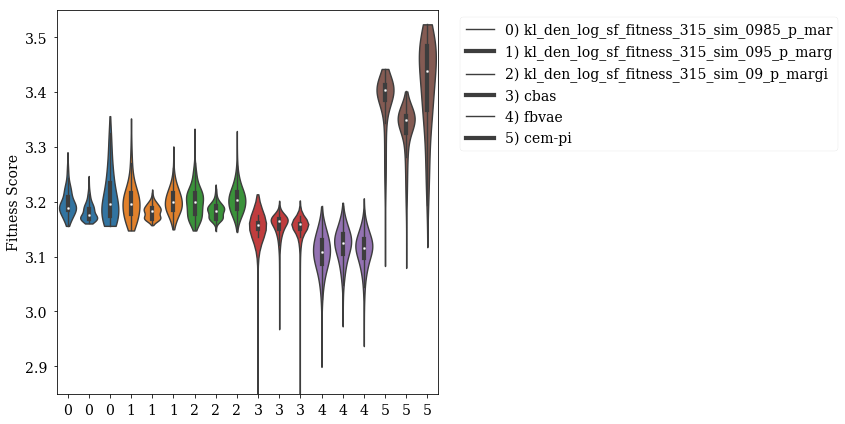

In [9]:
plot_comparison_violins(repeat_start=0, repeats=1, figsize=(12, 6), use_from=10, use_first=50, methods_to_use=METHODS, sort_by='oracle', min_y_val=2.85, max_y_val=3.55)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


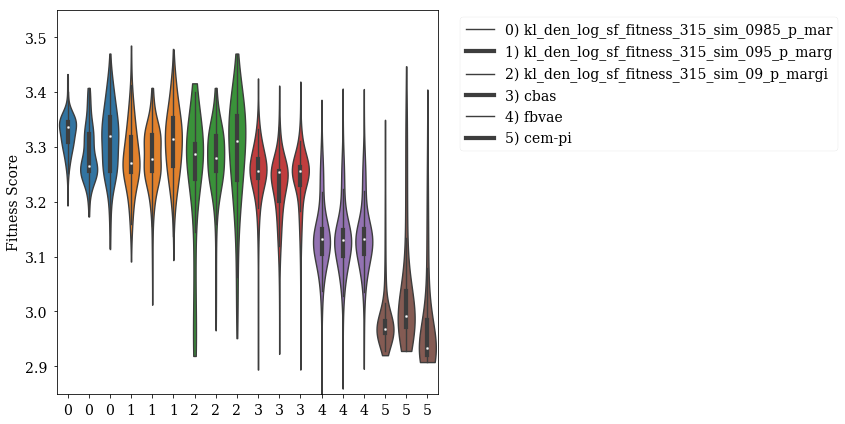

In [10]:
plot_comparison_violins(repeat_start=0, repeats=1, figsize=(12, 6), use_from=10, use_first=50, methods_to_use=METHODS, sort_by='ground_truth', min_y_val=2.85, max_y_val=3.55)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


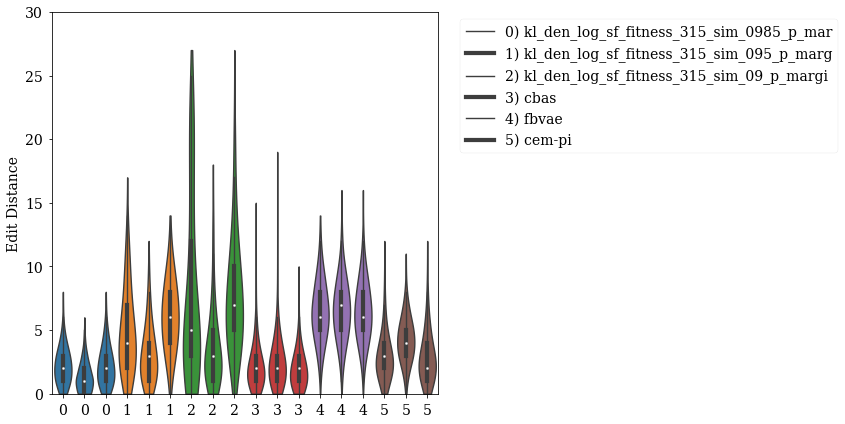

In [11]:
plot_comparison_violins(repeat_start=0, repeats=1, figsize=(12, 6), use_from=10, use_first=50, methods_to_use=METHODS, sort_by='edit_distance', min_y_val=0, max_y_val=30)